# Weather Prediction

&emsp;This project demonstrates the process of building a `temperature predictive model` that consists of `data cleaning`, `exploratory data analysis`, `data preprocessing` for modelling, `feature engineering`, and `model building`. The data is based on the weather information collected at the *Oakland International Airport* from *1960* to *2021*.

&emsp;


Oakland International Airport. The data is from 1960 through 2021

1. [Import Data](#import)
2. [Data Cleaning](#clean)
3. [Exploratory Data Analysis](#explore)
4. [Data Preprocessing](#preprocess)
5. [Ridge Model](#model)
6. [Additional Features](#add_features)

In [3]:
# Data manipulation
import numpy as np
import pandas as pd
import datetime
# Data visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
mpl.style.use('fivethirtyeight')
%matplotlib inline
# Model selection
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

# Stationarity test
from statsmodels.tsa.stattools import adfuller
# Order searching
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
# Seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
# Modelling
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

## <a id='import'>1 - Import Data</a>

In [4]:
weather = pd.read_csv("local_weather.csv", index_col="DATE")
weather.index = weather.index.astype('datetime64[ns]')

print(f"Row: {weather.shape[0]}\nColumn: {weather.shape[1]}")

weather.head()

Row: 16859
Column: 35


,STATION,NAME,ACMH,ACSH,AWND,DAPR,FMTM,FRGT,MDPR,PGTM,...,WT01,WT02,WT03,WT04,WT05,WT07,WT08,WT09,WT16,WT18
DATE,,,,,,,,,,,,,,,,,,,,,
1960-01-01,USW00023230,"OAKLAND INTERNATIONAL AIRPORT, CA US",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-01-02,USW00023230,"OAKLAND INTERNATIONAL AIRPORT, CA US",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
1960-01-03,USW00023230,"OAKLAND INTERNATIONAL AIRPORT, CA US",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-01-04,USW00023230,"OAKLAND INTERNATIONAL AIRPORT, CA US",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-01-05,USW00023230,"OAKLAND INTERNATIONAL AIRPORT, CA US",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


* `Five` informative columns are retained: `precipitation`, `snow`, `snow depth`, `min temperature`, `max temperature`.

In [5]:
weather = weather.loc[:, ["PRCP", "SNOW", "SNWD", "TMIN", "TMAX"]]
weather.columns = ["precipitation", "snow", "snow_depth", "min_temp", "max_temp"]
weather.head()

,precipitation,snow,snow_depth,min_temp,max_temp
DATE,,,,,
1960-01-01,0.0,0.0,0.0,30.0,49.0
1960-01-02,0.0,0.0,0.0,29.0,49.0
1960-01-03,0.0,0.0,0.0,35.0,54.0
1960-01-04,0.0,0.0,0.0,36.0,54.0
1960-01-05,0.0,0.0,0.0,33.0,55.0


In [6]:
weather.describe()

,precipitation,snow,snow_depth,min_temp,max_temp
count,16578.00000,11380.000000,11504.0,16849.000000,16850.000000
mean,0.04774,0.000088,0.0,50.431539,65.675668
std,0.18704,0.009374,0.0,6.739899,8.382314
min,0.00000,0.000000,0.0,1.000000,38.000000
25%,0.00000,0.000000,0.0,46.000000,60.000000
50%,0.00000,0.000000,0.0,51.000000,65.000000
75%,0.00000,0.000000,0.0,56.000000,71.000000
max,4.53000,1.000000,0.0,69.000000,122.000000


In [7]:
weather['snow'].value_counts()

snow
0.0    11379
1.0        1
Name: count, dtype: int64

* All columns have missing values.
* `snow` has `boolean` data type. However, only `one` record has the value of `1` while all others have `0`.
* `snow_depth` contains no information.

In [8]:
weather.drop(columns=['snow', 'snow_depth'], inplace=True)
weather.head(2)

,precipitation,min_temp,max_temp
DATE,,,
1960-01-01,0.0,30.0,49.0
1960-01-02,0.0,29.0,49.0


## <a id='clean'>2 - Data Cleaning</a>

### Precipitation

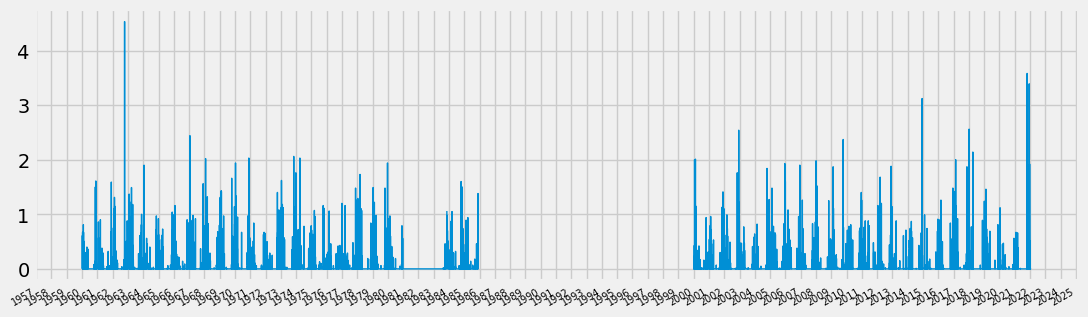

In [9]:
fig = plt.figure(figsize=(12,4))
plt.plot(weather['precipitation'], lw=1)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gcf().autofmt_xdate()
plt.xticks(fontsize=7)

plt.show()

* Most `precipitation` values are `0`.
* There is a clear gap somewhere around the year of `1985` and `2000`.

In [10]:
print(
    f"Percentage of missing values during the years from 1985 to 2000: {
        weather.loc[(weather['precipitation'].isna()) & (datetime.datetime(1985,1,1) < weather.index) & (weather.index < datetime.datetime(2000,12,31)), 'precipitation'].isna().sum()/weather.loc[(weather['precipitation'].isna()) & (datetime.datetime(1984,1,1) < weather.index) & (weather.index < datetime.datetime(2001,12,31)), 'precipitation'].shape[0]*100
        }%"
)

Percentage of missing values during the years from 1985 to 2000: 99.59839357429718%


* Due to the siginificant amount of consecutive `precipitation` values missing, those records within the period are removed. Others are replaced by `0`.

In [11]:
# Drop instances with missing precipitation values within the period from year 1985 to 2000.
preci_na_1985_2000_index = weather.loc[(weather['precipitation'].isna()) & (datetime.datetime(1985,1,1) < weather.index) & (weather.index < datetime.datetime(2000,12,31)), 'precipitation'].index
weather_drop = weather.drop(index=[index for index in preci_na_1985_2000_index])
# Replace missing precipitation values with 0 for other instances.
weather_drop.fillna({'precipitation': 0} , inplace=True)
weather_drop['precipitation'].isna().sum()

0

### Min Temp

In [12]:
weather_drop.loc[weather_drop['min_temp'].isna(), :].index

DatetimeIndex(['2004-11-20', '2011-12-21', '2011-12-22', '2011-12-23',
               '2011-12-24', '2011-12-25', '2013-06-16', '2020-08-29',
               '2020-09-08', '2020-09-09'],
              dtype='datetime64[ns]', name='DATE', freq=None)

* Given the number of missing values in `min_temp` is insignificant, replacing the values with their preceding values would not affect the model dramatically.

In [13]:
weather_drop['min_temp'] = weather_drop['min_temp'].ffill()
weather_drop['min_temp'].isna().sum()

0

### Max Temp

In [14]:
weather_drop.loc[weather_drop['max_temp'].isna(), :].index

DatetimeIndex(['2004-11-20', '2013-06-16', '2019-04-18', '2019-04-21',
               '2019-04-22', '2020-08-29', '2020-09-08', '2020-09-09',
               '2021-10-31'],
              dtype='datetime64[ns]', name='DATE', freq=None)

* Same case goes to `max_temp`. Missing values are replaced by preceding values.

In [15]:
weather_drop['max_temp'] = weather_drop['max_temp'].ffill()
weather_drop['max_temp'].isna().sum()

0

In [16]:
weather_drop.isna().sum()

precipitation    0
min_temp         0
max_temp         0
dtype: int64

## <a id='explore'>3 - Exploratory Data Analysis</a>

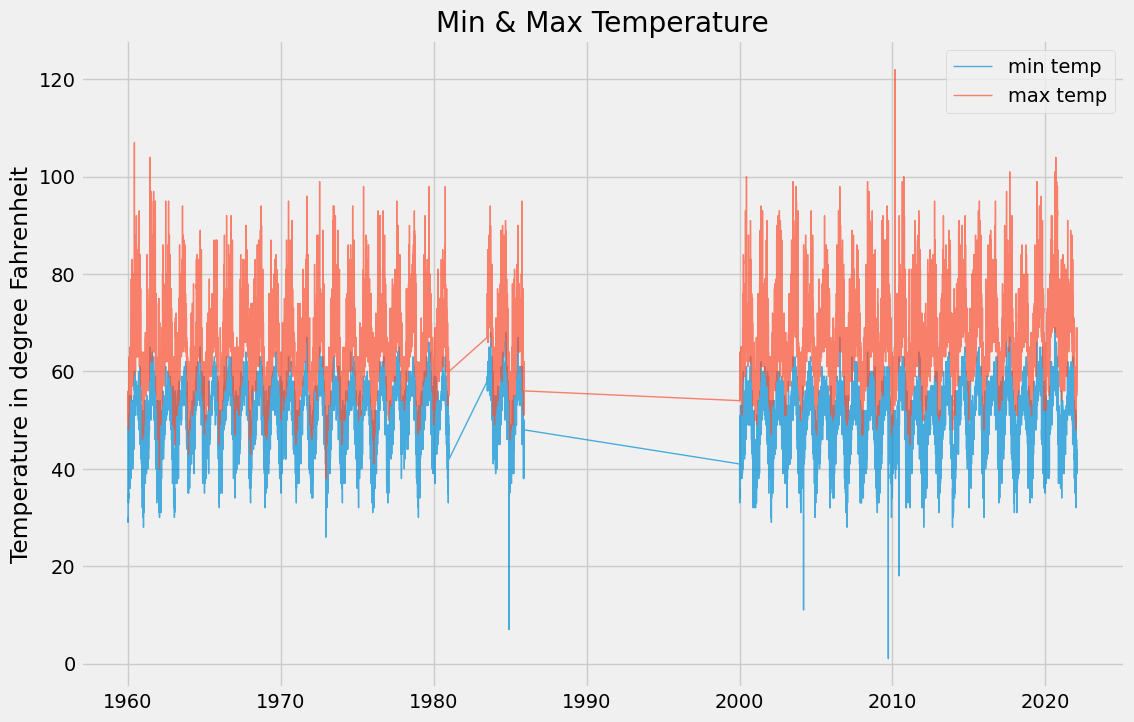

In [17]:
plt.figure(figsize=(12,8))
plt.plot(weather_drop['min_temp'], lw=1, alpha=.7, label='min temp')
plt.plot(weather_drop['max_temp'], lw=1, alpha=.7, label='max temp')
plt.title("Min & Max Temperature")
plt.ylabel("Temperature in degree Fahrenheit")
plt.legend()
plt.show()

* Both `min` and `max` temperature apparently have the same oscillation over the decades.
* The large window of missing values in the plot is due to the removal of instances with missing `precipicitation` values.

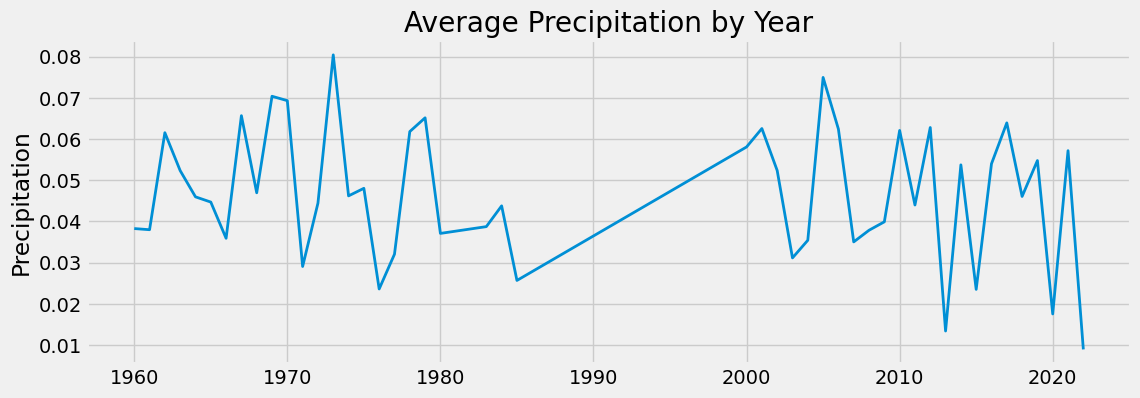

In [18]:
preci_by_year = weather_drop.groupby(by=lambda x: x.year)['precipitation'].agg('mean')

plt.figure(figsize=(12,4))
plt.plot(preci_by_year, lw=2)
plt.title("Average Precipitation by Year")
plt.ylabel("Precipitation")
plt.show()

* The average `precipitation` by year plot shows that the oscilliation seems to get larger over time.
* In the last decade, the average `precipitation` is generally lower than the preceding years.

## <a id='preprocess'>4 - Data Preprocessing</a>

* The dependent variable for the model is the `max_temp` of the following day.

In [19]:
weather_drop['y'] = weather_drop['max_temp'].shift(-1)
weather_drop.drop(index=weather_drop.index[-1], inplace=True)
weather_drop.tail()

,precipitation,min_temp,max_temp,y
DATE,,,,
2022-01-23,0.0,41.0,60.0,60.0
2022-01-24,0.0,39.0,60.0,57.0
2022-01-25,0.0,43.0,57.0,57.0
2022-01-26,0.0,41.0,57.0,67.0
2022-01-27,0.0,39.0,67.0,64.0


In [20]:
# Train test split
# Train set takes 60% of the data, validation set takes 20% of the data, and test set takes 20% of the data.
train_size = int(len(weather_drop)*0.6)
val_size = int(len(weather_drop)*0.2)
test_size = len(weather_drop) - train_size - val_size

train = weather_drop.iloc[:train_size]
val = weather_drop.iloc[train_size:train_size+val_size]
test = weather_drop.iloc[train_size+val_size:]

print(f"Train: {train.shape[0]}\nValidation: {val.shape[0]}\nTest: {test.shape[0]}")

Train: 9966
Validation: 3322
Test: 3322


In [21]:
X_train, y_train = train.drop(columns='y'), train['y']
X_val, y_val = val.drop(columns='y'), val['y']
X_test, y_test = test.drop(columns='y'), test['y']

## <a id="model">5 - Ridge Model</a>

In [22]:
model = Ridge()
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_val = model.predict(X_val)

print(f"Train MAE: {mean_absolute_error(y_train, pred_train)}")
print(f"Validation MAE: {mean_absolute_error(y_val, pred_val)}")

Train MAE: 3.386262621299555
Validation MAE: 3.6506197512472633


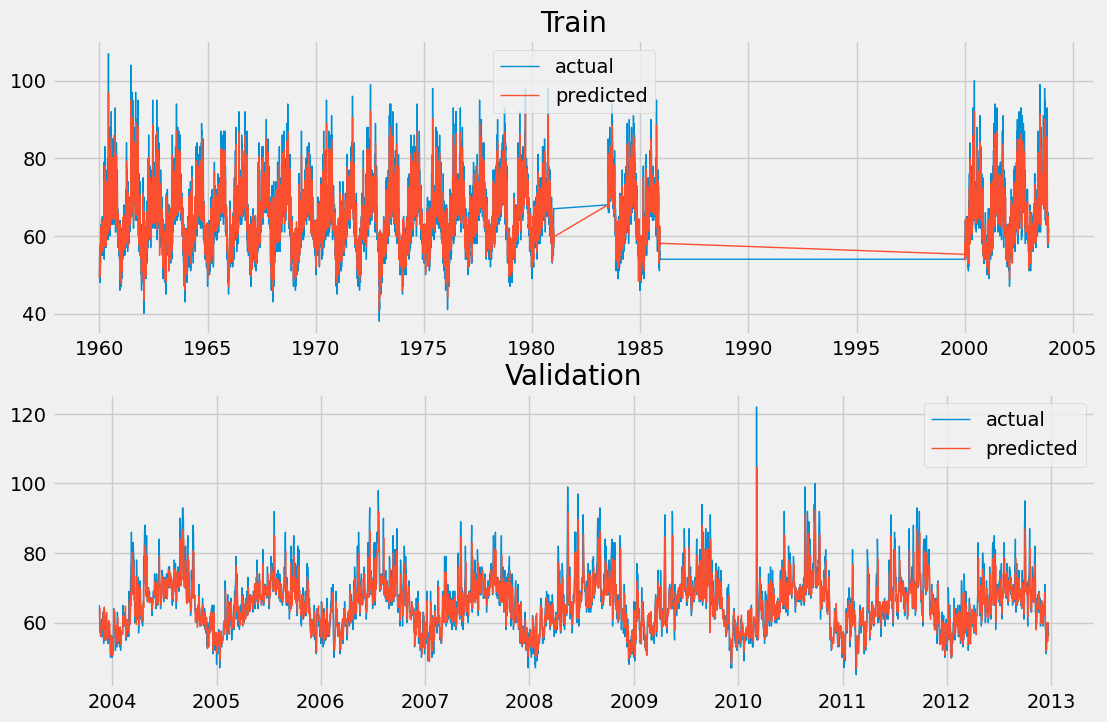

In [23]:
fig, axes = plt.subplots(2, 1, figsize=(12,8))

axes[0].plot(y_train, lw=1, label='actual')
axes[0].plot(X_train.index, pred_train, lw=1, label='predicted')
axes[0].set_title("Train")
axes[0].legend()

axes[1].plot(y_val, lw=1, label='actual')
axes[1].plot(X_val.index, pred_val, lw=1, label='predicted')
axes[1].set_title("Validation")
axes[1].legend()

plt.show()

* The predictions on both `training` and `validation` sets are able to align with the trend.

Test MAE: 3.461535587073077


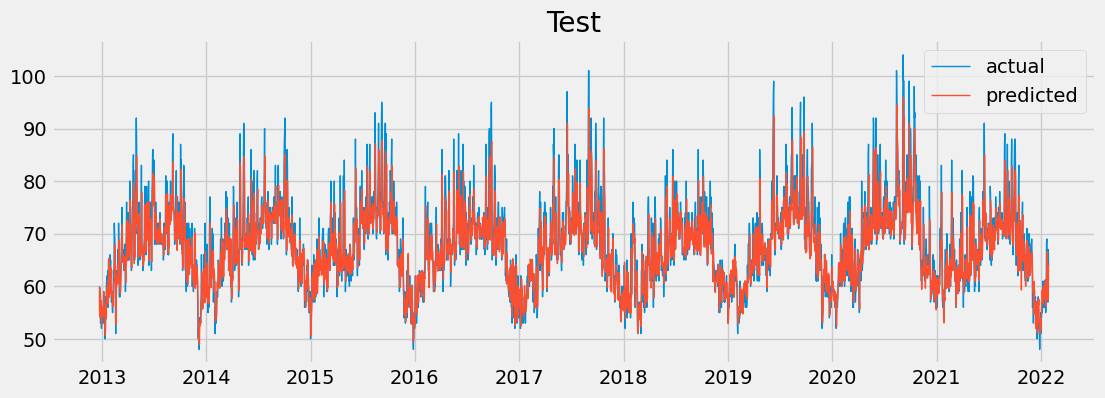

In [24]:
# Test set
pred_test = model.predict(X_test)
print(f"Test MAE: {mean_absolute_error(y_test, pred_test)}")

plt.figure(figsize=(12,4))
plt.plot(y_test, lw=1, label='actual')
plt.plot(X_test.index, pred_test, lw=1, label='predicted')
plt.title("Test")
plt.legend()
plt.show()

* Predictions on `test` set also align with the original `target` values.
* The `mean absolute error` of all predictions are about the same at around $~3.5$.

In [25]:
# Function to split, train, and predict
def modelling(dataframe, target, model):
    '''
    A pipeline function to split the data, train the model, and predict the target.
    -----
    dataframe: DataFrame
        The data to be used for the model.
    target: str
        The target variable.
    model: object
        The model to be used.
    -----
    return: (model, dataframe, dataframe, dataframe)
        The trained model and the three dataframes that consists of true target values and prediction values for training, validation, and test sets respectively.
    '''
    # Train test split
    train_size = int(len(dataframe)*0.6)
    val_size = int(len(dataframe)*0.2)
    test_size = len(dataframe) - train_size - val_size

    train = dataframe.iloc[:train_size]
    val = dataframe.iloc[train_size:train_size+val_size]
    test = dataframe.iloc[train_size+val_size:]

    X_train, y_train = train.drop(columns=target), train[target]
    X_val, y_val = val.drop(columns=target), val[target]
    X_test, y_test = test.drop(columns=target), test[target]

    # Train the model
    model.fit(X_train, y_train)
    pred_train = model.predict(X_train)
    pred_val = model.predict(X_val)
    pred_test = model.predict(X_test)

    print(f"Train MAE: {mean_absolute_error(y_train, pred_train)}")
    print(f"Validation MAE: {mean_absolute_error(y_val, pred_val)}")
    print(f"Test MAE: {mean_absolute_error(y_test, pred_test)}")

    # Plot the results
    fig, axes = plt.subplots(3, 1, figsize=(12,12))

    axes[0].plot(y_train, lw=1, label='actual')
    axes[0].plot(X_train.index, pred_train, lw=1, label='predicted')
    axes[0].set_title("Train")
    axes[0].legend()

    axes[1].plot(y_val, lw=1, label='actual')
    axes[1].plot(X_val.index, pred_val, lw=1, label='predicted')
    axes[1].set_title("Validation")
    axes[1].legend()

    axes[2].plot(y_test, lw=1, label='actual')
    axes[2].plot(X_test.index, pred_test, lw=1, label='predicted')
    axes[2].set_title("Test")
    axes[2].legend()

    plt.show()

    # Dataframes
    train_result = pd.DataFrame({'actual': y_train, 'predicted': pred_train})
    val_result = pd.DataFrame({'actual': y_val, 'predicted': pred_val})
    test_result = pd.DataFrame({'actual': y_test, 'predicted': pred_test})

    return model, train_result, val_result, test_result

## <a id='add_features'>6 - Additional Features</a>

In [26]:
weather_drop['avg_min_temp_30'] = weather_drop['min_temp'].rolling(window=30).mean()
weather_drop['avg_max_temp_30'] = weather_drop['max_temp'].rolling(window=30).mean()
weather_drop['min_temp_ratio'] = weather_drop['min_temp'] / weather_drop.groupby(pd.Grouper(freq='M'))['min_temp'].transform('mean')
weather_drop['max_temp_ratio'] = weather_drop['max_temp'] / weather_drop.groupby(pd.Grouper(freq='M'))['max_temp'].transform('mean')
weather_drop['avg_preci_30'] = weather_drop['precipitation'].rolling(window=30).mean()

# The first 30 instances have missing values due to the rolling window.
na_index = weather_drop.loc[weather_drop['avg_min_temp_30'].isna(), :].index
weather_drop.drop(index=na_index, inplace=True)
weather_drop.isna().sum().sum()

/var/folders/_6/8qgcbw5x5cqgmt_5s5b28mpw0000gn/T/ipykernel_17566/987464284.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  weather_drop['min_temp_ratio'] = weather_drop['min_temp'] / weather_drop.groupby(pd.Grouper(freq='M'))['min_temp'].transform('mean')
/var/folders/_6/8qgcbw5x5cqgmt_5s5b28mpw0000gn/T/ipykernel_17566/987464284.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  weather_drop['max_temp_ratio'] = weather_drop['max_temp'] / weather_drop.groupby(pd.Grouper(freq='M'))['max_temp'].transform('mean')


0

Train MAE: 3.2272215044242376
Validation MAE: 3.4818624687984054
Test MAE: 3.2570479096289424


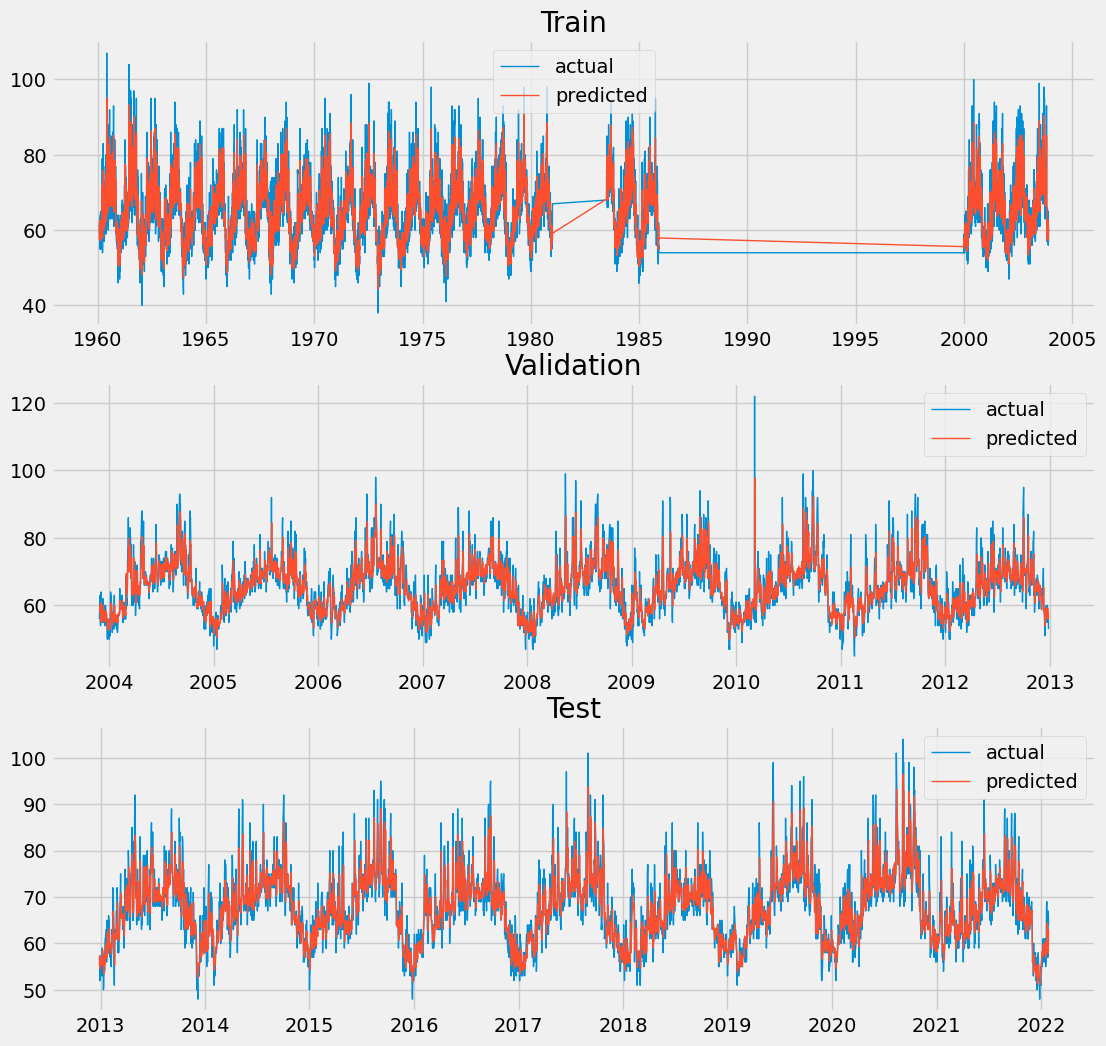

In [27]:
model, train_result, val_result, test_result = modelling(weather_drop, 'y', Ridge())

* The `MAE` for all three sets of predictions are improved slightly after the addition of the four engineered features.

## <a id='arimax'>7 - ARIMAX Model</a>

### Stationarity

In [28]:
adfuller(weather_drop['y'])

(-9.835263169259385,
 4.914671805346142e-17,
 23,
 16557,
 {'1%': -3.430745018066121,
  '5%': -2.8617145821023566,
  '10%': -2.566862925630026},
 97434.06950960521)

&emsp;With no differencing, $p$ value is significant and the test statistic is $-9.84$. Thus, null hypothesis that the time series is non-stationary can be rejected.

### Orders

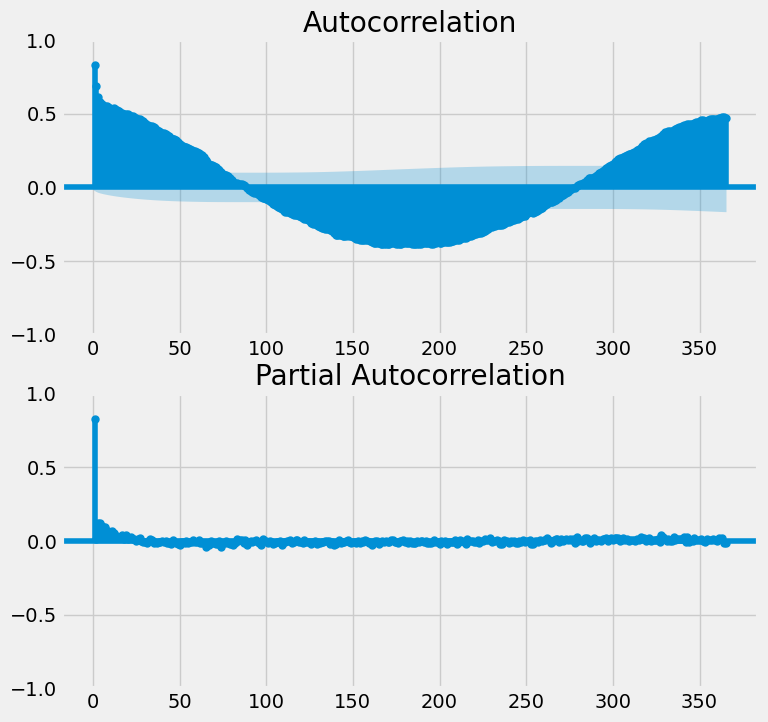

In [32]:
# plot ACF and PACF graphs
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8))

plot_acf(y_train, lags=365, zero=False, ax=ax1)
plot_pacf(y_train, lags=365, zero=False, ax=ax2)
plt.show()

* PACF plot shows tail off. `AR` model is recommended.

In [33]:
# Search for the best order by AIC and BIC
order_aic_bic = []

for p in range(5):
    for q in range(5):
        try:
            model = ARIMA(y_train, order=(p,0,q))
            results = model.fit()
            order_aic_bic.append((p, q, results.aic, results.bic))
        except:
            order_aic_bic.append((p, q, None, None))

order_df = pd.DataFrame(order_aic_bic, columns=['p', 'q', 'aic', 'bic'])

/opt/anaconda3/envs/venv_timeseries/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/venv_timeseries/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/venv_timeseries/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/venv_timeseries/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated 

In [35]:
order_df.sort_values(['aic', 'bic']).head()

,p,q,aic,bic
17,3,2,58203.530473,58253.979015
21,4,1,58204.405927,58254.854469
23,4,3,58207.363552,58272.225963
16,3,1,58207.726426,58250.968033
14,2,4,58208.333233,58265.988709


&emsp;The order (3,0,2) yields the best `AIC` value.

### Seasonal Pattern